In [ ]:
# Exercise 2 (Lab 4)

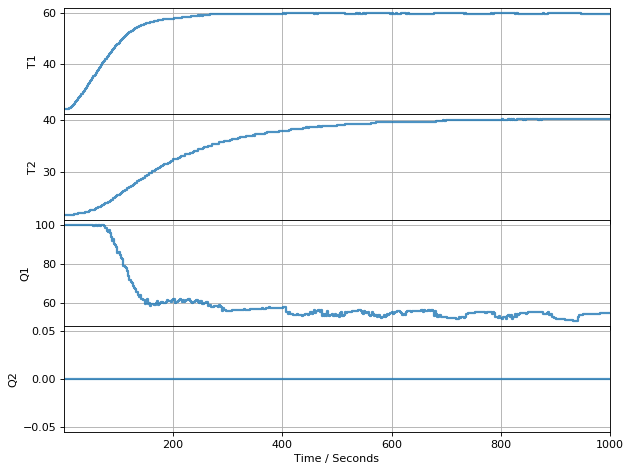

TCLab disconnected successfully.


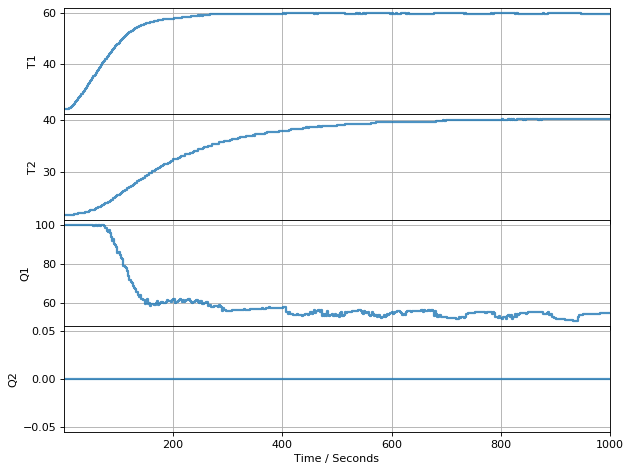

In [1]:
# Verify performance of the inner controller to a step change in setpoint. 
# You're looking for a step response with minimal or no overshoot of the setpoint. 

# This step response occurs without a disturbance from heater 2

# PI controller from Lab 3 (with anti-integral windup)

%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup


# add anti-integral windup feature

def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV)) # <==== range limits
        e_prev = e


# final time and time step
t_final = 1000
t_step = 5

# perform experiment

# create a function that introduces the setpoint but with NO disturbance
def experiment(controller, t_final, t_step=5,
               SP=lambda t: 60, # step change in SP occurs at time 0 (goes from T_amb to 60)
               DV=lambda t: 0): # no disturbance occurs
    
    TCLab = setup(connected=True)
    with TCLab() as lab:
        
        lab.P1 = 255
        lab.P2 = 50
        
        h = Historian(lab.sources)
        p = Plotter(h, t_final)
        for t in clock(t_final):
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((t_step, SP(t), T1, U1))    # <==== send U1 to controller 
            lab.Q1(U1)

            p.update(t)  
    h.to_csv('lab4_ex2_step_change_1.csv')
    
# control parameters

controller = PI_antiwindup(10.0, 0.06, MV_bar=0,MV_min=0,MV_max=100) 

# manipulate Kp/Ki here to get the desired response - these are the inner loop gain values

controller.send(None)

experiment(controller,t_final,t_step)


# step test completed without a disturbance, then fit model to T2

In [22]:
# Read data into panda dataframe

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# read data file from the Github repository into a Pandas dataframe
data_location = "lab4_ex2_step_change_1.csv"
expt = pd.read_csv(data_location)

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)


,T1,T2,Q1,Q2
Time,,,,
0.00,22.091,21.865,100.000,0.0
2.00,21.994,21.865,100.000,0.0
4.00,22.188,21.865,100.000,0.0
6.00,22.188,21.865,100.000,0.0
8.00,22.220,21.865,100.000,0.0
...,...,...,...,...
992.02,59.893,40.234,55.046,0.0
994.02,59.893,40.234,55.078,0.0
996.02,59.893,40.234,55.110,0.0


In [23]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg. C.")
    ax[0].set_title("Temperature Response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("Percent")
    ax[1].set_title("Heater Power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("Residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return


Time
0.00       0.135000
2.00       0.135000
4.00       0.135000
6.00       0.135000
8.00       0.135000
             ...   
992.02     0.673578
994.02     0.674628
996.02     0.675666
998.02     0.676693
1000.02    0.677708
Name: T2, Length: 501, dtype: float64

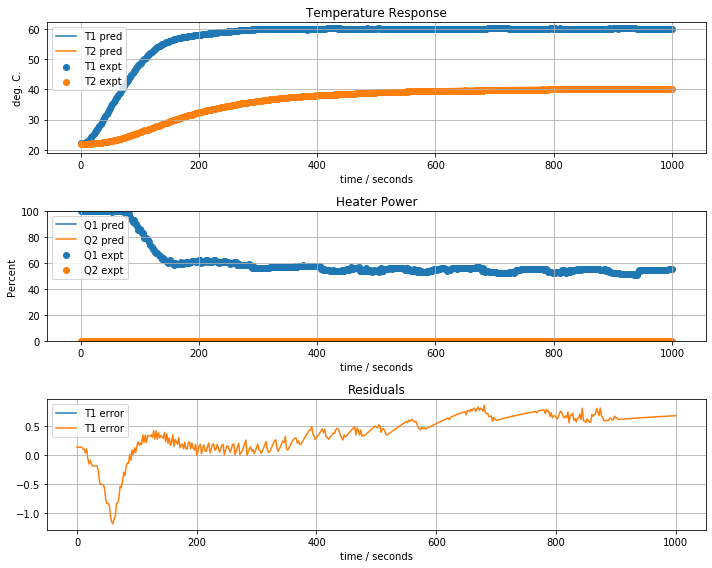

In [43]:
# FIRST ORDER PLUS DEAD TIME (FOPDT) - use this to model T2 for the outer controller

# parameter values and units
T_amb = 22                 # deg C
u1bar = 60 - T_amb # magnitude of step change of setpoint 1
t_expt = expt.index

# adjustable parameters
K = 0.5
tau = 175
t_delay = 60

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T2"] = [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt] # u1 bar is the magnitude of step change
    if plot:
        plot_data(expt, pred)
    return pred["T2"] - expt["T2"]
    
model_first_order_delay([K, tau, t_delay], True)

K = 0.4818429612716343,  tau = 168.9928708849076, time delay = 58.65460989598015


Time
0.00       0.135000
2.00       0.135000
4.00       0.135000
6.00       0.135000
8.00       0.135000
             ...   
992.02     0.002913
994.02     0.003773
996.02     0.004623
998.02     0.005463
1000.02    0.006294
Name: T2, Length: 501, dtype: float64

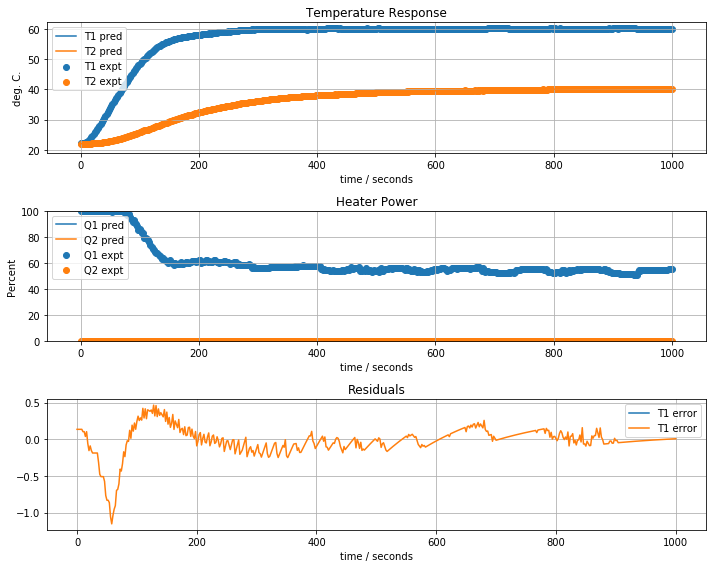

In [25]:
# Use least squares fit
results = least_squares(model_first_order_delay,  [K, tau, t_delay])
K, tau, t_delay = results.x
print(f"K = {K},  tau = {tau}, time delay = {t_delay}")
model_first_order_delay(results.x, True)

In [44]:
# Estimate the time constant and dead time to a step change in setpoint. 

time_cst = 168.99287
t_delay = 58.6546

print('An estimate of the time constant of a step change in setpoint is:',time_cst,'seconds.')
print('An estimate of the dead time to a step change in setpoint is:',t_delay,'seconds.')

An estimate of the time constant of a step change in setpoint is: 168.99287 seconds.
An estimate of the dead time to a step change in setpoint is: 58.6546 seconds.


In [45]:
# Need a step-test to determine the outer controller parameters (using the inner controller)

# Using empirical tuning rules, estimate proportional and integral gains for outer PI controller.
# Use the Astrom and Murray tuning rules (see Notebook 3.5) to estimate values for the PI control parameters 𝐾𝑃  and  𝐾𝐼 .

# From the inner loop response of T2:

gain = 0.48184

Kp_val = (0.15*t_delay+0.35*time_cst)/(gain*t_delay)
print('The estimated value for proportional gain, Kp, is:',round(Kp_val,5))

Ki_val = (0.46*t_delay+0.02*time_cst)/(gain*t_delay**2)
print('The estimated value for integral gain, Ki, is:',round(Ki_val,5))

The estimated value for proportional gain, Kp, is: 2.40412
The estimated value for integral gain, Ki, is: 0.01832


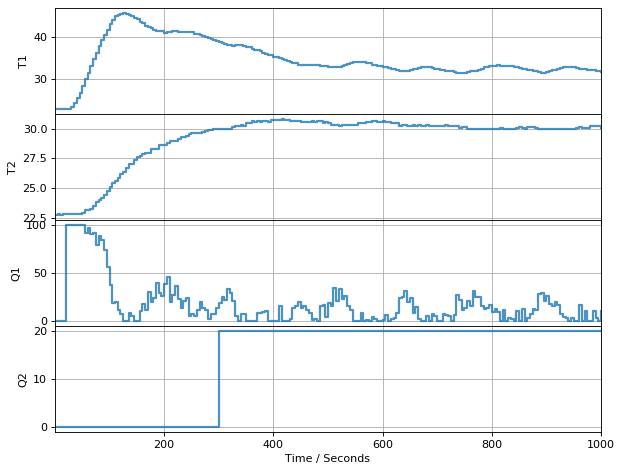

TCLab disconnected successfully.


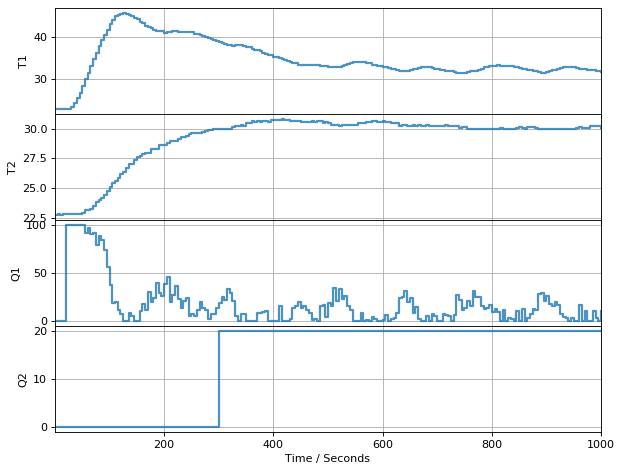

In [37]:
# For the cascade control loop, perform the same testing as you did for the first exercise. 
# Does cascade control improve closed response with respect to setpoint tracking? 
# With respect to disturbance rejection? Explain what you see.


# add anti-integral windup feature (added in again)

def PI_antiwindup_2(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):  
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV)) # <==== range limits
        e_prev = e
        
        
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

# Set parameters
t_final = 1000
t_step = 5

T_amb = 21

# Set the proportional/integral gain values (calculated from the step change response in part 1)
Kp_inner = 10
Ki_inner = 0.06

# Outer proportiona/integral gain values (calculated using tuning rules from inner loop response values)
Kp_outer = 2.40412
Ki_outer = 0.01832


# create a function that introduces the setpoint and the disturbance
def experiment_2(inner_control,outer_control, t_final, t_step,
               SP2=lambda t: 30 if t >= 20 else 0, 
               DV=lambda t: 20 if t >= 300 else 0):


    TCLab = setup(connected=True)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variables
        lab.P1 = 255
        lab.P2 = 50
        
        # create instances of the controllers
        next(inner_control)
        SP1 = next(outer_control) # initializes SP1 (outer control gives the first value of SP1)

    
        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            T2 = lab.T2
            U1 = lab.Q1()                            # <==== new line
            
            SP1 = outer_control.send((t_step,SP2(t), T2, SP1))     
            U1 = inner_control.send((t_step, SP1, T1, U1))    
            
            lab.Q1(U1) 
            lab.Q2(DV(t)) # <==== disturbance
            p.update(t)  
            
        h.to_csv('lab4_exercise2_cascade.csv')

        
# create two controllers
inner_control = PI_antiwindup(Kp_inner,Ki_inner,MV_min=0,MV_max=100)
# inner control MV is heater 1 power
outer_control = PI_antiwindup(5*Kp_outer,5*Ki_outer,MV_min=T_amb,MV_max=80)
# outer control MV is SP1 for inner control

# call the experiment
experiment_2(inner_control,outer_control,t_final,t_step)




In [ ]:
# Note: after running several trials of the cascade control with my arduino device, I was able to find manipulated values of Kp and Ki that gave a 
# more desirable result for the setpoint tracking by T2. 

# Does cascade control improve closed response with respect to setpoint tracking? 

# For this trial of the experiment, compared to exercise 1, the cascade control greatly improved the closed response with respect to setpoint tracking. 
# There was much less of an overshoot of the setpoint (over 30 degrees C. by approx. 1 degree).

# With respect to disturbance rejection. Explain what you see.

# For this trial of the experiment, the disturbance rejection by the cascade controller worked effectively because
# there is only a slight rise in T2's temperature due to the disturbance. 


# (Note: One of my trials, without the manipulation of the Kp and Ki values of the outer loop is included after this experimental trial.)
